# Online Retail Analysis & Forecasting

#### Analisis data transaksi online retail, RFM segmentation, dan perbandingan forecasting (ARIMA vs Prophet).

Analisis data transaksi retail online untuk memahami perilaku pelanggan dan memprediksi pendapatan masa depan.
Dataset: Online Retail Dataset (UCI Repository)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/online-retail-dataset/Online Retail.xlsx


## 1. Import Library & Load Dataset
Tujuan:
- Mengimpor semua library yang dibutuhkan
- Memuat dataset utama
- Melihat struktur awal data (ukuran, tipe kolom, contoh isi)

In [2]:
!pip install pmdarima prophet --quiet

# Import library utama
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Untuk forecasting
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from prophet import Prophet

# Pengaturan tampilan
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10,5)

# Load dataset
df = pd.read_excel("/kaggle/input/online-retail-dataset/Online Retail.xlsx")

# Cek ukuran dan informasi awal
print("📏 Dimensi data:", df.shape)
print("\n📋 Informasi dataset:")
df.info()

# Lihat 5 baris pertama
df.head()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 29.5 MB/s eta 0:00:0000:0100:01
📏 Dimensi data: (541909, 8)

📋 Informasi dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## 2. Data Cleaning & Preprocessing
Tujuan:
- Menghapus data kosong dan duplikat
- Menghapus transaksi tidak valid (retur)
- Mengubah tipe tanggal
- Menambahkan kolom baru (`Revenue`, `Month`, `Year`) untuk analisis

### Notes :
- Data dengan `CustomerID` kosong tidak bisa dikaitkan dengan pelanggan → dihapus  
- Transaksi negatif (`Quantity` atau `UnitPrice`) menandakan retur → dikeluarkan  
- Menambahkan `Revenue`, `Month`, dan `Year` akan membantu saat melakukan analisis tren penjualan dan forecasting  
- Hasil bersih disimpan sebagai `cleaned_online_retail.csv` untuk tahap analisis berikutnya

### Cek missing values

In [3]:
print("🔍 Jumlah missing values per kolom:")
print(df.isnull().sum())

🔍 Jumlah missing values per kolom:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


### Hapus baris tanpa CustomerID (tidak bisa dianalisis)

In [4]:
df = df.dropna(subset=['CustomerID'])

### Hapus duplikasi data

In [5]:
before = df.shape[0]
df = df.drop_duplicates()
after = df.shape[0]
print(f"\n🧹 Dihapus {before - after} baris duplikat.")


🧹 Dihapus 5225 baris duplikat.


### Hapus transaksi tidak valid (Quantity & UnitPrice <= 0)

In [6]:
before_invalid = df.shape[0]
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
after_invalid = df.shape[0]
print(f"🚫 Dihapus {before_invalid - after_invalid} baris transaksi tidak valid.")

🚫 Dihapus 8912 baris transaksi tidak valid.


Langkah ini bertujuan untuk membersihkan data transaksi yang tidak masuk akal, yaitu transaksi dengan:
- Quantity (jumlah barang) ≤ 0
- UnitPrice (harga per unit) ≤ 0

Nilai negatif atau nol pada dua kolom tersebut biasanya menandakan:
- Kesalahan input data (misalnya salah ketik atau sistem error).
- Retur barang atau transaksi pembatalan (refund) yang tidak relevan untuk analisis penjualan.

Dengan memfilter data hanya yang memiliki Quantity > 0 dan UnitPrice > 0, maka dataset hanya menyisakan transaksi valid yang benar-benar menghasilkan pendapatan.

### Konversi kolom tanggal

In [7]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

Langkah ini dilakukan untuk mengonversi kolom InvoiceDate dari format string menjadi format datetime (tipe data waktu).
Pada dataset Online Retail, kolom InvoiceDate biasanya tersimpan sebagai teks (misalnya "2010-12-01 08:26:00"), sehingga Python tidak bisa langsung memprosesnya sebagai data waktu.

#### Alasan:
Tanpa konversi ini, analisis berbasis waktu akan sulit dilakukan karena sistem hanya akan mengenali InvoiceDate sebagai teks biasa, bukan urutan kronologis.
Konversi ke tipe datetime adalah tahap dasar namun krusial untuk memastikan data bisa diproses secara temporal (berdasarkan waktu).

### Tambahkan kolom Revenue

In [8]:
df['Revenue'] = df['Quantity'] * df['UnitPrice']

Langkah ini digunakan untuk menambahkan kolom baru bernama Revenue, yang merepresentasikan pendapatan dari setiap transaksi.
Pendapatan dihitung dengan rumus:

> ***Revenue = Quantity × UnitPrice***

Alasan:
Penambahan kolom ini sangat penting karena revenue adalah metrik utama untuk analisis performa bisnis.

Kolom ini memungkinkan analisis seperti:
- Mengetahui produk dengan penjualan tertinggi.
- Menghitung total pendapatan per bulan, negara, atau pelanggan.
- Menjadi dasar untuk forecasting pendapatan di masa depan.

Tanpa kolom ini, sulit untuk melakukan analisis keuangan yang menggambarkan kinerja penjualan perusahaan secara akurat. Kolom Revenue merupakan variabel target utama dalam analisis penjualan dan prediksi pendapatan.

### Tambahkan kolom waktu tambahan

In [9]:
# Tambah kolom bulan dan tahun
df['Month'] = df['InvoiceDate'].dt.month
df['Year'] = df['InvoiceDate'].dt.year

# Simpan hasil cleaning
df.to_csv("cleaned_online_retail.csv", index=False)


Langkah ini menambahkan dua kolom baru, yaitu:

Month → diambil dari bagian bulan pada kolom InvoiceDate
Year → diambil dari bagian tahun pada kolom InvoiceDate

Dengan mengekstrak informasi waktu ini, dataset menjadi lebih mudah untuk dilakukan analisis temporal seperti tren bulanan atau tahunan.

Alasan:
- Analisis tren penjualan per bulan/tahun, misalnya untuk melihat musim penjualan tertinggi.
- Forecasting revenue, karena model peramalan membutuhkan data time series yang terstruktur.
- Visualisasi performa bisnis berdasarkan waktu, seperti grafik penjualan bulanan atau tahunan.

Menyimpan hasil cleaning ke dalam file *cleaned_online_retail.csv* bertujuan agar proses analisis berikutnya lebih efisien, tanpa perlu mengulangi tahap pembersihan data dari awal.

In [10]:
print("\n✅ Data cleaning selesai!")
print("📏 Ukuran data akhir:", df.shape)

# Tampilkan 5 baris data hasil cleaning
df.head()


✅ Data cleaning selesai!
📏 Ukuran data akhir: (392692, 11)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,Month,Year
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,12,2010
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,12,2010
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,12,2010
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,12,2010
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,12,2010


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392692 entries, 0 to 541908
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392692 non-null  object        
 1   StockCode    392692 non-null  object        
 2   Description  392692 non-null  object        
 3   Quantity     392692 non-null  int64         
 4   InvoiceDate  392692 non-null  datetime64[ns]
 5   UnitPrice    392692 non-null  float64       
 6   CustomerID   392692 non-null  float64       
 7   Country      392692 non-null  object        
 8   Revenue      392692 non-null  float64       
 9   Month        392692 non-null  int32         
 10  Year         392692 non-null  int32         
dtypes: datetime64[ns](1), float64(3), int32(2), int64(1), object(4)
memory usage: 33.0+ MB


In [12]:
print("Total transaksi:", df['InvoiceNo'].nunique())
print("Total pelanggan unik:", df['CustomerID'].nunique())
print("Total pendapatan:", df['Revenue'].sum())
print("Negara terbanyak membeli:", df['Country'].value_counts().head(5))


Total transaksi: 18532
Total pelanggan unik: 4338
Total pendapatan: 8887208.894000001
Negara terbanyak membeli: Country
United Kingdom    349203
Germany             9025
France              8326
EIRE                7226
Spain               2479
Name: count, dtype: int64


## 3. Exploratory Data Analysis (EDA)
Tujuan:
- Memahami karakteristik dataset
- Menemukan pola penjualan & perilaku pelanggan
- Menyiapkan insight awal sebelum forecasting

### A. Statistik Deskriptif

In [13]:
# Statistik deskriptif untuk kolom numerik
print("📊 Statistik Deskriptif:")
df.describe()

📊 Statistik Deskriptif:


,Quantity,InvoiceDate,UnitPrice,CustomerID,Revenue,Month,Year
count,392692.000000,392692,392692.000000,392692.000000,392692.000000,392692.000000,392692.000000
mean,13.119702,2011-07-10 19:13:07.771892480,3.125914,15287.843865,22.631500,7.601871,2010.934631
min,1.000000,2010-12-01 08:26:00,0.001000,12346.000000,0.001000,1.000000,2010.000000
25%,2.000000,2011-04-07 11:12:00,1.250000,13955.000000,4.950000,5.000000,2011.000000
50%,6.000000,2011-07-31 12:02:00,1.950000,15150.000000,12.450000,8.000000,2011.000000
75%,12.000000,2011-10-20 12:53:00,3.750000,16791.000000,19.800000,11.000000,2011.000000
max,80995.000000,2011-12-09 12:50:00,8142.750000,18287.000000,168469.600000,12.000000,2011.000000
std,180.492832,NaN,22.241836,1713.539549,311.099224,3.415015,0.247177


Penjelasan : 
- count → jumlah data yang valid (bukan NaN)
- mean → rata-rata nilai
- std → standar deviasi (tingkat sebaran data)
- min → nilai minimum
- 25%, 50%, 75% → kuartil (membagi data menjadi empat bagian)
- max → nilai maksimum

Statistik deskriptif sangat penting pada tahap Exploratory Data Analysis (EDA) karena membantu:
- Memahami karakteristik data sebelum analisis lanjutan.
- Mendeteksi nilai ekstrem atau outlier (misalnya Quantity yang sangat besar atau negatif).
- Menilai kualitas data — apakah data terlihat realistis dan konsisten.
- Menentukan langkah preprocessing berikutnya, seperti normalisasi, transformasi log, atau penanganan outlier.

### B. Top 10 Produk Terlaris

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127942 (\N{TROPHY}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


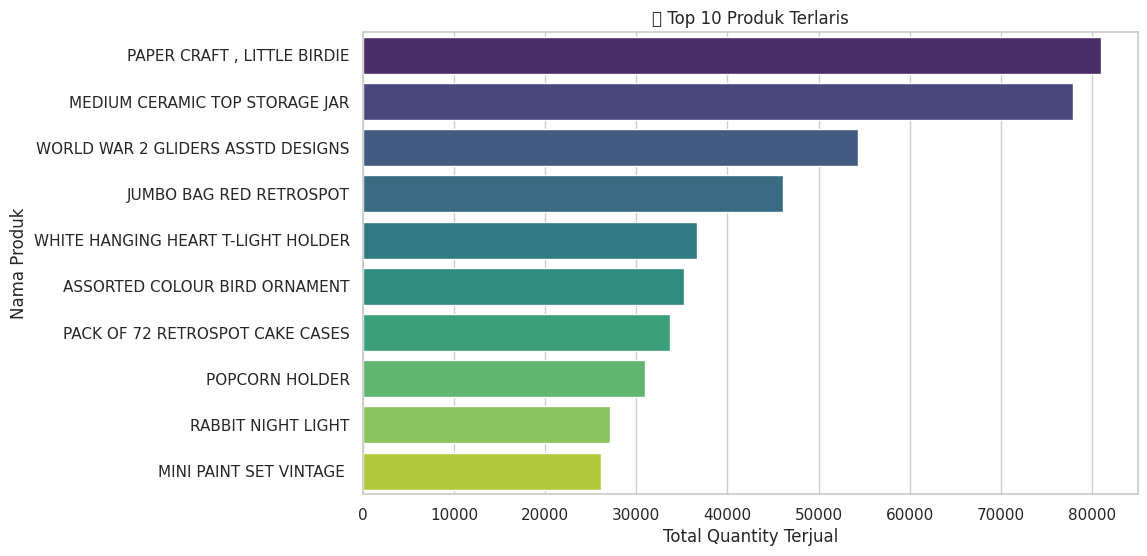

Description
PAPER CRAFT , LITTLE BIRDIE           80995
MEDIUM CERAMIC TOP STORAGE JAR        77916
WORLD WAR 2 GLIDERS ASSTD DESIGNS     54319
JUMBO BAG RED RETROSPOT               46078
WHITE HANGING HEART T-LIGHT HOLDER    36706
ASSORTED COLOUR BIRD ORNAMENT         35263
PACK OF 72 RETROSPOT CAKE CASES       33670
POPCORN HOLDER                        30919
RABBIT NIGHT LIGHT                    27153
MINI PAINT SET VINTAGE                26076
Name: Quantity, dtype: int64

In [14]:
    # Hitung total quantity per produk
    top_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
    
    # Visualisasi
    plt.figure(figsize=(10,6))
    sns.barplot(x=top_products.values, y=top_products.index, palette="viridis")
    plt.title("🏆 Top 10 Produk Terlaris")
    plt.xlabel("Total Quantity Terjual")
    plt.ylabel("Nama Produk")
    plt.show()
    
    top_products

Analisis Top 10 Produk Terlaris penting untuk:

- Mengetahui produk dengan permintaan tertinggi → bisa menjadi fokus strategi pemasaran.
- Membantu manajemen stok → produk populer perlu stok lebih banyak.
- Mendukung keputusan bisnis → menentukan promosi, bundling, atau rekomendasi produk.
- Mengidentifikasi pola pembelian pelanggan → apakah penjualan didominasi produk tertentu atau merata.

### C. Negara dengan Revenue Tertinggi

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


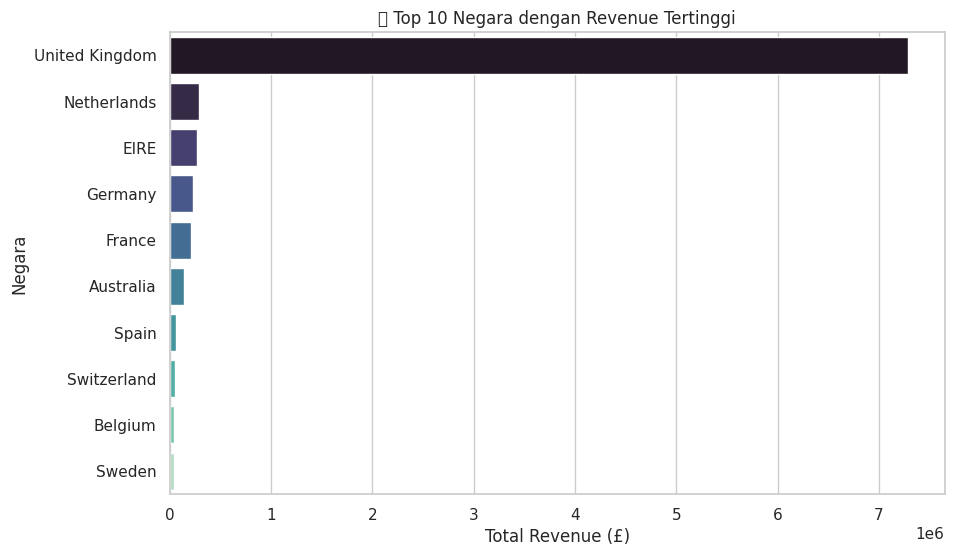

Country
United Kingdom    7285024.644
Netherlands        285446.340
EIRE               265262.460
Germany            228678.400
France             208934.310
Australia          138453.810
Spain               61558.560
Switzerland         56443.950
Belgium             41196.340
Sweden              38367.830
Name: Revenue, dtype: float64

In [15]:
# Total revenue per negara
top_countries = df.groupby('Country')['Revenue'].sum().sort_values(ascending=False).head(10)

# Visualisasi
plt.figure(figsize=(10,6))
sns.barplot(x=top_countries.values, y=top_countries.index, palette="mako")
plt.title("🌍 Top 10 Negara dengan Revenue Tertinggi")
plt.xlabel("Total Revenue (£)")
plt.ylabel("Negara")
plt.show()

top_countries


### D. Tren Revenue Bulanan

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


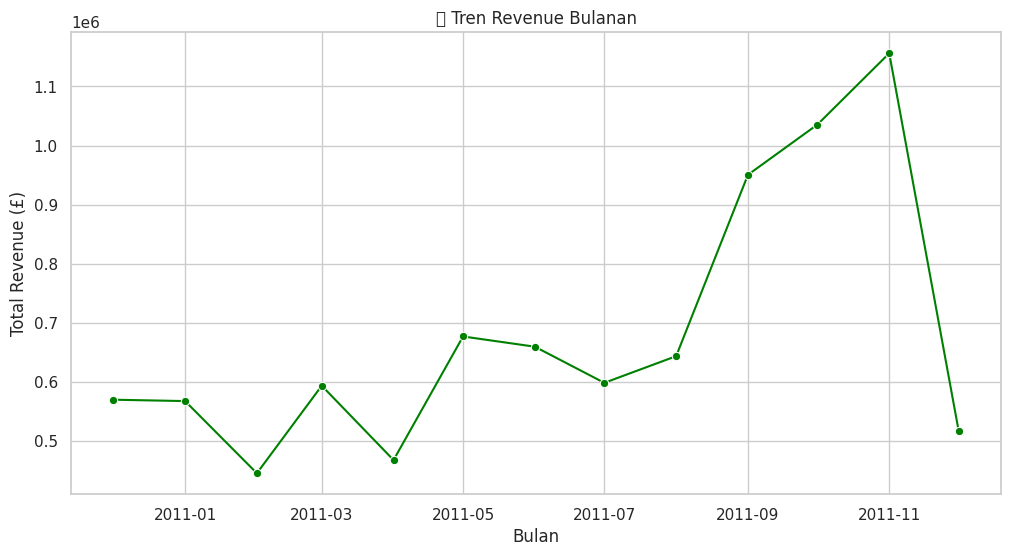

,Year,Month,Revenue,Date
8,2011,8,644051.040,2011-08-01
9,2011,9,950690.202,2011-09-01
10,2011,10,1035642.450,2011-10-01
11,2011,11,1156205.610,2011-11-01
12,2011,12,517190.440,2011-12-01


In [16]:
# Group berdasarkan tahun dan bulan
monthly_revenue = df.groupby(['Year','Month'])['Revenue'].sum().reset_index()

# Gabungkan jadi satu kolom tanggal (YYYY-MM)
monthly_revenue['Date'] = pd.to_datetime(monthly_revenue[['Year','Month']].assign(DAY=1))

# Visualisasi tren revenue per bulan
plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_revenue, x='Date', y='Revenue', marker='o', color='green')
plt.title("📈 Tren Revenue Bulanan")
plt.xlabel("Bulan")
plt.ylabel("Total Revenue (£)")
plt.show()

monthly_revenue.tail()


### E. Jumlah Transaksi per Bulan

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129534 (\N{RECEIPT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


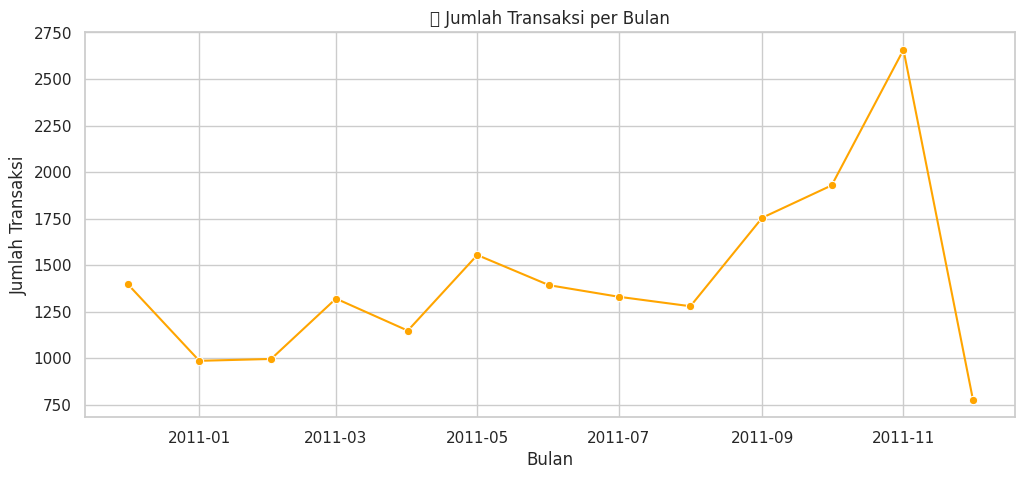

,Year,Month,InvoiceNo,Date
8,2011,8,1280,2011-08-01
9,2011,9,1755,2011-09-01
10,2011,10,1929,2011-10-01
11,2011,11,2657,2011-11-01
12,2011,12,778,2011-12-01


In [17]:
# Hitung jumlah transaksi unik per bulan
monthly_transactions = df.groupby(['Year','Month'])['InvoiceNo'].nunique().reset_index()
monthly_transactions['Date'] = pd.to_datetime(monthly_transactions[['Year','Month']].assign(DAY=1))

# Visualisasi
plt.figure(figsize=(12,5))
sns.lineplot(data=monthly_transactions, x='Date', y='InvoiceNo', marker='o', color='orange')
plt.title("🧾 Jumlah Transaksi per Bulan")
plt.xlabel("Bulan")
plt.ylabel("Jumlah Transaksi")
plt.show()

monthly_transactions.tail()


### F. Distribusi Revenue per Pelanggan

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


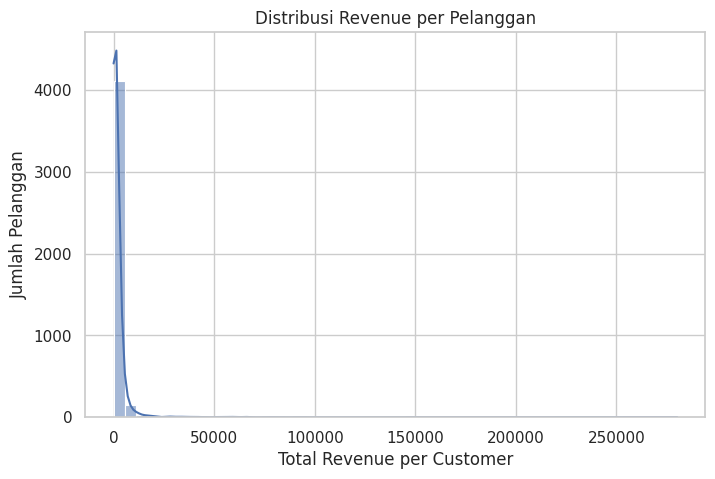

In [18]:
customer_revenue = df.groupby('CustomerID')['Revenue'].sum().reset_index()

plt.figure(figsize=(8,5))
sns.histplot(customer_revenue['Revenue'], bins=50, kde=True)
plt.title("Distribusi Revenue per Pelanggan")
plt.xlabel("Total Revenue per Customer")
plt.ylabel("Jumlah Pelanggan")
plt.show()


### Heatmap Korelasi Variabel Numerik

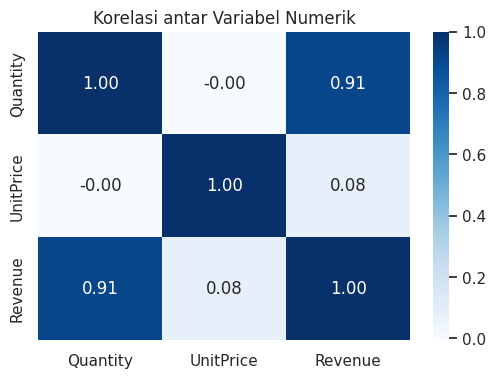

In [19]:
# Pilih kolom numerik
numeric_df = df[['Quantity', 'UnitPrice', 'Revenue']]

# Hitung korelasi
corr = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap='Blues', fmt='.2f')
plt.title('Korelasi antar Variabel Numerik')
plt.show()


Insight:

Korelasi positif tinggi antara Quantity dan Revenue menandakan semakin banyak barang dibeli, semakin tinggi pendapatan.

UnitPrice biasanya memiliki korelasi lemah terhadap Quantity karena harga tidak selalu menentukan jumlah pembelian.

Korelasi rendah antar variabel lain menunjukkan bahwa model prediksi mungkin perlu mempertimbangkan variabel tambahan seperti waktu atau pelanggan.

### Analisis Outlier (Nilai Ekstrem)

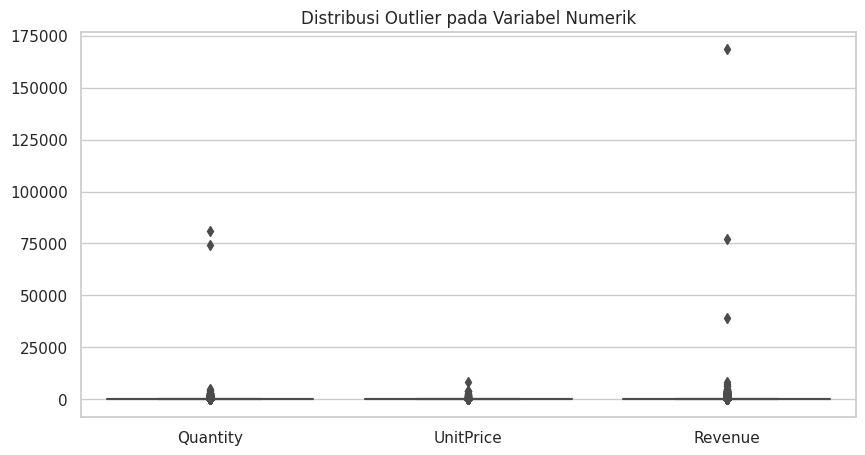

In [20]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df[['Quantity', 'UnitPrice', 'Revenue']])
plt.title('Distribusi Outlier pada Variabel Numerik')
plt.show()


Insight:

Terlihat adanya beberapa nilai ekstrem terutama pada Revenue — kemungkinan disebabkan oleh pembelian dalam jumlah besar atau kesalahan pencatatan.

Nilai-nilai outlier tidak selalu dihapus; pada konteks bisnis, transaksi besar bisa sangat relevan dan mencerminkan perilaku pelanggan premium.

### Agregasi bulanan untuk analisis tren dan forecasting

In [21]:
# pastikan InvoiceDate sudah datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# agregasi bulanan (sum revenue)
monthly_revenue = (
    df.set_index('InvoiceDate')
      .resample('M')['Revenue']
      .sum()
      .to_frame()
      .rename(columns={'Revenue':'Revenue'})
)

# ubah index jadi bulanan (rapi untuk plotting)
monthly_revenue.index = monthly_revenue.index.to_period('M').to_timestamp()
monthly_revenue.head()


/tmp/ipykernel_37/3686522563.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M')['Revenue']


,Revenue
InvoiceDate,
2010-12-01,570422.730
2011-01-01,568101.310
2011-02-01,446084.920
2011-03-01,594081.760
2011-04-01,468374.331


Langkah ini bertujuan untuk mengubah data transaksi yang awalnya bersifat harian atau per transaksi menjadi agregasi bulanan, sehingga lebih mudah dianalisis dalam konteks waktu (time series). Proses agregasi dilakukan berdasarkan kolom InvoiceDate, yang menunjukkan tanggal transaksi, dan Revenue, yang merupakan hasil kali antara Quantity dan UnitPrice.

“Agregasi bulanan dilakukan untuk menyederhanakan data transaksi harian menjadi total pendapatan per bulan, sehingga dapat digunakan untuk analisis tren, peramalan penjualan, dan identifikasi pola musiman secara lebih efektif.”

### Buat train/test time split (misal 80% train, 20% test berdasarkan waktu)

In [22]:
# Split time-based (contoh: 80% data untuk training, 20% untuk testing)
split_date = monthly_revenue.index[int(len(monthly_revenue)*0.8)]

train = monthly_revenue[monthly_revenue.index <= split_date]
test = monthly_revenue[monthly_revenue.index > split_date]

print("📘 Train data:", train.shape)
print("📗 Test data:", test.shape)
print("🕓 Split date:", split_date)


📘 Train data: (11, 1)
📗 Test data: (2, 1)
🕓 Split date: 2011-10-01 00:00:00


#### Train/Test Time Split (80% : 20%)

Bagian ini membagi data deret waktu (**time series**) menjadi **data latih (train)** dan **data uji (test)** berdasarkan **urutan waktu**, bukan acak.  

- `split_date` menentukan batas waktu di mana 80% data pertama digunakan untuk pelatihan dan 20% sisanya untuk pengujian.  
- `train` berisi data sebelum `split_date`, sedangkan `test` berisi data sesudahnya.

**Alasan:**
1. Dalam time series, urutan waktu penting — data masa depan tidak boleh digunakan untuk melatih model.  
2. Pembagian ini memastikan model belajar dari masa lalu dan diuji pada data masa depan yang realistis.  
3. Membantu mengevaluasi kemampuan model dalam **memprediksi tren ke depan**.

## 4. RFM Analysis (Recency, Frequency, Monetary)

Tabel RFM (5 baris pertama):


,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40



Statistik Deskriptif RFM:


,CustomerID,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4338.000000,4338.000000
mean,15300.408022,92.536422,4.272015,2048.688081
std,1721.808492,100.014169,7.697998,8985.230220
min,12346.000000,1.000000,1.000000,3.750000
25%,13813.250000,18.000000,1.000000,306.482500
50%,15299.500000,51.000000,2.000000,668.570000
75%,16778.750000,142.000000,5.000000,1660.597500
max,18287.000000,374.000000,209.000000,280206.020000


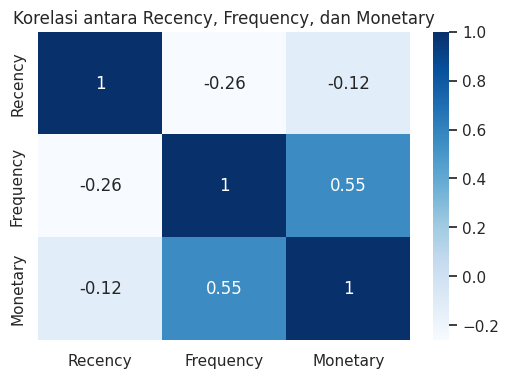

In [23]:
# RFM ANALYSIS
# Tujuan: Mengelompokkan pelanggan berdasarkan perilaku pembelian mereka

from datetime import timedelta

# Pastikan kolom InvoiceDate sudah dalam format datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Tentukan tanggal referensi (hari setelah transaksi terakhir)
reference_date = df['InvoiceDate'].max() + timedelta(days=1)

# Hitung RFM
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                   # Frequency
    'Revenue': 'sum'                                          # Monetary
}).reset_index()

# Ubah nama kolom
rfm.rename(columns={'InvoiceDate': 'Recency', 
                    'InvoiceNo': 'Frequency', 
                    'Revenue': 'Monetary'}, inplace=True)

# Lihat hasil awal
print("Tabel RFM (5 baris pertama):")
display(rfm.head())

# Statistik umum
print("\nStatistik Deskriptif RFM:")
display(rfm.describe())

# Korelasi antar RFM
plt.figure(figsize=(6,4))
sns.heatmap(rfm[['Recency','Frequency','Monetary']].corr(), annot=True, cmap='Blues')
plt.title("Korelasi antara Recency, Frequency, dan Monetary")
plt.show()


Bagian ini bertujuan untuk **menganalisis perilaku pelanggan** berdasarkan tiga metrik utama:

- **Recency** → Jumlah hari sejak transaksi terakhir pelanggan (semakin kecil, semakin baru). 
- **Frequency** → Jumlah transaksi unik yang dilakukan pelanggan (semakin tinggi, semakin sering).  
- **Monetary** → Total pendapatan yang dihasilkan pelanggan (semakin besar, semakin bernilai).

**Langkah:**
1. `reference_date` ditetapkan sebagai hari setelah transaksi terakhir agar Recency dapat dihitung dengan benar.  
2. Data dikelompokkan berdasarkan `CustomerID` untuk menghitung ketiga metrik.  
3. Korelasi antar RFM divisualisasikan untuk memahami hubungan antar dimensi perilaku pelanggan.

**Alasan:**
- RFM membantu **segmentasi pelanggan** berdasarkan nilai dan aktivitas mereka.  
- Berguna dalam strategi **retensi, promosi, dan personalisasi pemasaran**.  
- Analisis korelasi membantu memahami keterkaitan antara seberapa sering, baru, dan besar nilai transaksi pelanggan.

### Clustering Pelanggan (K-Means)

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:8

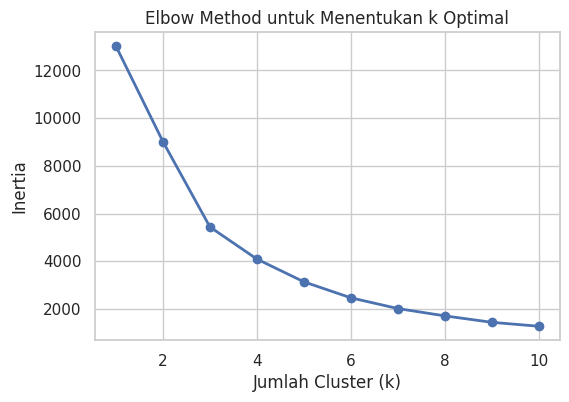

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Normalisasi data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency','Frequency','Monetary']])

# Cari jumlah cluster optimal dengan Elbow Method
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

# Visualisasi Elbow Method
plt.figure(figsize=(6,4))
plt.plot(K, inertia, 'o-', linewidth=2)
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method untuk Menentukan k Optimal')
plt.show()


Bagian ini bertujuan untuk **mengelompokkan pelanggan** berdasarkan kesamaan perilaku pembelian mereka dari hasil RFM.

**Langkah:**
1. Data RFM dinormalisasi menggunakan `StandardScaler` agar setiap variabel (Recency, Frequency, Monetary) memiliki skala yang seimbang.  
2. Algoritma **K-Means** digunakan untuk melakukan clustering.  
3. Metode **Elbow** digunakan untuk menentukan jumlah cluster optimal dengan melihat titik di mana penurunan nilai *inertia* mulai melambat (titik “siku”).

**Alasan:**
- K-Means efektif untuk segmentasi pelanggan berdasarkan pola perilaku yang mirip.  
- Normalisasi penting agar fitur dengan nilai besar (seperti Monetary) tidak mendominasi proses clustering.  
- Elbow Method membantu memilih jumlah cluster yang paling efisien dan representatif.

### Clustering & Analisis

Ringkasan Setiap Cluster:


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Cluster,Recency,Frequency,Monetary,Num_Customers
0,0,248.564030,1.551789,476.330547,1062
1,1,15.672986,22.047393,12435.086682,211
2,2,7.384615,82.538462,127187.959231,13
3,3,43.920380,3.656291,1344.724473,3052


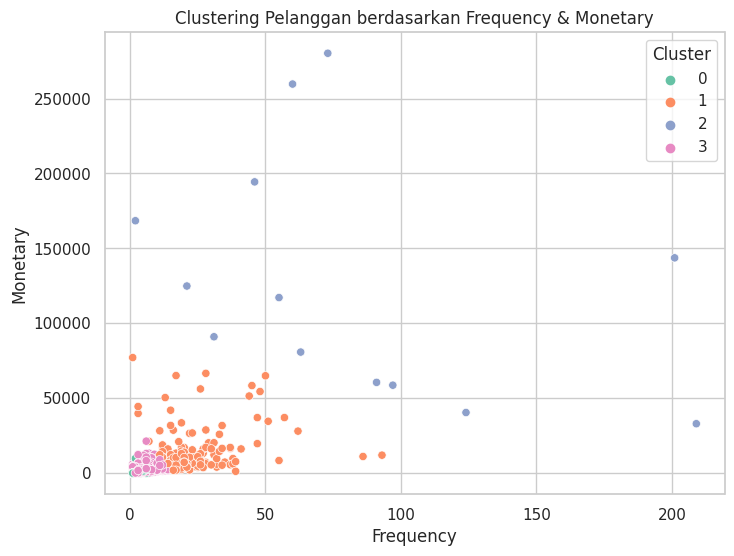

In [25]:
# Misal kita pilih k=4 berdasarkan Elbow
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Analisis rata-rata tiap cluster
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'Num_Customers'}).reset_index()

print("Ringkasan Setiap Cluster:")
display(cluster_summary)

# Visualisasi scatter Frequency vs Monetary
plt.figure(figsize=(8,6))
sns.scatterplot(data=rfm, x='Frequency', y='Monetary', hue='Cluster', palette='Set2')
plt.title('Clustering Pelanggan berdasarkan Frequency & Monetary')
plt.show()


Pada tahap ini dilakukan penerapan **K-Means Clustering** dengan jumlah cluster (k) = 4, yang dipilih berdasarkan hasil *Elbow Method*.

**Langkah:**
1. Model K-Means digunakan untuk mengelompokkan pelanggan ke dalam 4 cluster berdasarkan nilai *Recency*, *Frequency*, dan *Monetary*.  
2. Dibuat ringkasan rata-rata tiap cluster untuk memahami karakteristiknya, seperti seberapa sering pelanggan bertransaksi atau seberapa besar total pembelian.  
3. Visualisasi scatter plot antara *Frequency* dan *Monetary* membantu melihat perbedaan antar cluster secara visual.

**Alasan:**
- Mengetahui segmen pelanggan (misal: pelanggan aktif, pelanggan potensial, pelanggan tidak aktif).  
- Hasil analisis dapat digunakan untuk strategi pemasaran yang lebih tepat sasaran sesuai perilaku tiap kelompok.

### Analisis Tiap Cluster

In [26]:
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(2)

cluster_summary


Recency Frequency   Monetary      
           mean      mean       mean count
Cluster                                   
0        248.56      1.55     476.33  1062
1         15.67     22.05   12435.09   211
2          7.38     82.54  127187.96    13
3         43.92      3.66    1344.72  3052

Berdasarkan hasil agregasi RFM tiap cluster:

| Cluster | Recency (rata-rata) | Frequency (rata-rata) | Monetary (rata-rata) | Jumlah Pelanggan | Karakteristik |
|:--:|:--:|:--:|:--:|:--:|:--|
| **0** | 248.56 | 1.55 | 476.33 | 1062 | Pelanggan lama dengan aktivitas rendah dan pembelian kecil. |
| **1** | 15.67 | 22.05 | 12,435.09 | 211 | Pelanggan aktif dengan frekuensi tinggi dan kontribusi pendapatan besar. |
| **2** | 7.38 | 82.54 | 127,187.96 | 13 | Pelanggan VIP dengan nilai transaksi sangat tinggi dan sangat aktif. |
| **3** | 43.92 | 3.66 | 1,344.72 | 3052 | Pelanggan reguler, masih cukup aktif dengan pembelian moderat. |

**Kesimpulan:**  
Cluster 2 dan 1 merupakan pelanggan paling bernilai dan loyal, sedangkan Cluster 0 berisiko churn karena jarang melakukan pembelian.

 ### Distribusi Jumlah Pelanggan per Cluster

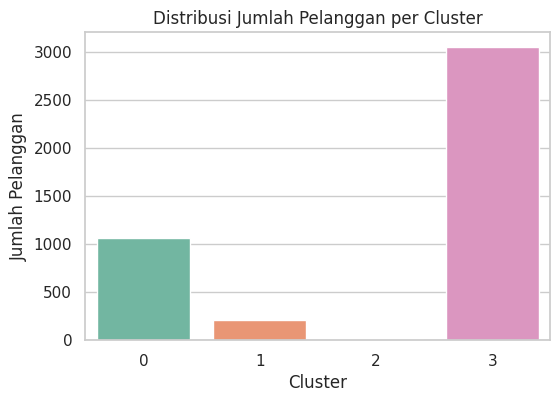

Jumlah pelanggan per cluster:


Cluster
0    1062
1     211
2      13
3    3052
Name: count, dtype: int64

In [27]:
# Distribusi jumlah pelanggan per cluster
cluster_counts = rfm['Cluster'].value_counts().sort_index()

plt.figure(figsize=(6,4))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='Set2')
plt.title('Distribusi Jumlah Pelanggan per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Jumlah Pelanggan')
plt.show()

print("Jumlah pelanggan per cluster:")
display(cluster_counts)


Hasil analisis menunjukkan:

- **Cluster 3** memiliki jumlah pelanggan terbanyak (3052), menandakan kelompok pelanggan reguler yang masih cukup aktif.
- **Cluster 0** berjumlah 1062 pelanggan, cenderung tidak aktif dan berisiko churn.
- **Cluster 1** berisi 211 pelanggan aktif dengan kontribusi besar terhadap pendapatan.
- **Cluster 2** hanya 13 pelanggan, namun bernilai tinggi (VIP customers).

**Kesimpulan:**  
Mayoritas pelanggan berada pada segmentasi reguler, sedangkan pelanggan paling bernilai (Cluster 2) jumlahnya sedikit namun penting untuk dijaga loyalitasnya.

### Ringkasan Statistik per Cluster (Boxplot dan Rata-rata)

Statistik RFM per Cluster:


Cluster                    0             1              2             3
Recency   count  1062.000000    211.000000      13.000000   3052.000000
          mean    248.564030     15.672986       7.384615     43.920380
          std      66.102662     40.288273      11.485777     36.187780
          min     144.000000      1.000000       1.000000      1.000000
          25%     190.000000      3.000000       1.000000     15.000000
          50%     243.000000      5.000000       2.000000     33.000000
          75%     300.500000     15.000000       8.000000     66.000000
          max     374.000000    372.000000      39.000000    163.000000
Frequency count  1062.000000    211.000000      13.000000   3052.000000
          mean      1.551789     22.047393      82.538462      3.656291
          std       1.071722     11.591361      63.264808      2.817888
          min       1.000000      1.000000       2.000000      1.000000
          25%       1.000000     15.000000      46.000000      1.000000
          50%       1.000000     19.000000      63.000000      3.000000
          75%       2.000000     25.000000      97.000000      5.000000
          max      12.000000     93.000000     209.000000     14.000000
Monetary  count  1062.000000    211.000000      13.000000   3052.000000
          mean    476.330547  12435.086682  127187.959231   1344.724473
          std     634.634463  13020.632376   79842.360609   1529.689015
          min       3.750000   1296.440000   33053.190000      6.200000
          25%     168.960000   5367.245000   60632.750000    382.097500
          50%     309.925000   7834.650000  117210.080000    820.095000
          75%     535.147500  13358.320000  168472.500000   1770.555000
          max    9864.260000  77183.600000  280206.020000  21429.390000

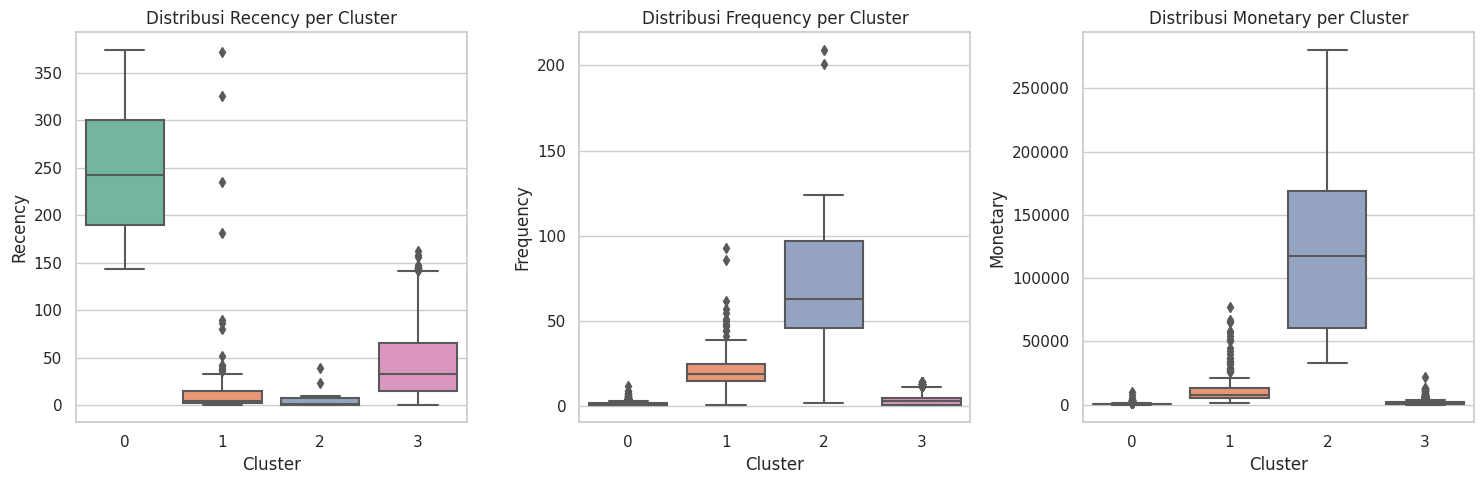

In [28]:
# Statistik ringkasan tiap cluster
print("Statistik RFM per Cluster:")
display(rfm.groupby('Cluster')[['Recency','Frequency','Monetary']].describe().T)

# Visualisasi boxplot untuk setiap variabel RFM
fig, axes = plt.subplots(1, 3, figsize=(15,5))

sns.boxplot(data=rfm, x='Cluster', y='Recency', ax=axes[0], palette='Set2')
axes[0].set_title('Distribusi Recency per Cluster')

sns.boxplot(data=rfm, x='Cluster', y='Frequency', ax=axes[1], palette='Set2')
axes[1].set_title('Distribusi Frequency per Cluster')

sns.boxplot(data=rfm, x='Cluster', y='Monetary', ax=axes[2], palette='Set2')
axes[2].set_title('Distribusi Monetary per Cluster')

plt.tight_layout()
plt.show()


Dari hasil analisis RFM:

- **Cluster 2 (VIP Customers)** memiliki *Recency* sangat rendah (≈7 hari), *Frequency* dan *Monetary* tertinggi — pelanggan paling aktif dan bernilai tinggi.  
- **Cluster 1 (Loyal High Spenders)** bertransaksi sering (≈22 kali) dengan nilai pembelian tinggi, meski sedikit kurang aktif dibanding Cluster 2.  
- **Cluster 3 (Regular Buyers)** masih aktif namun memiliki nilai transaksi menengah.  
- **Cluster 0 (Inactive Customers)** memiliki *Recency* tinggi (jarang beli) dan *Monetary* rendah, menandakan pelanggan yang hampir tidak aktif.

**Kesimpulan:**  
Distribusi boxplot memperkuat bahwa Cluster 2 dan 1 adalah target utama untuk retensi dan promosi premium, sedangkan Cluster 0 perlu reaktivasi.

## 5. Forecasting Revenue Bulanan (ARIMA vs Prophet)
Tujuan
Memprediksi pendapatan (Revenue) untuk 6 bulan ke depan berdasarkan tren historis.
Ini akan menjawab rumusan masalah tentang “bagaimana proyeksi pendapatan perusahaan dalam jangka pendek” dan menjadi dasar pengambilan keputusan bisnis.

### A. Persiapan Data Time Series

/tmp/ipykernel_37/1312665900.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_revenue = df.groupby(pd.Grouper(key='InvoiceDate', freq='M'))['Revenue'].sum().reset_index()


,Date,Revenue
0,2010-12-31,570422.730
1,2011-01-31,568101.310
2,2011-02-28,446084.920
3,2011-03-31,594081.760
4,2011-04-30,468374.331


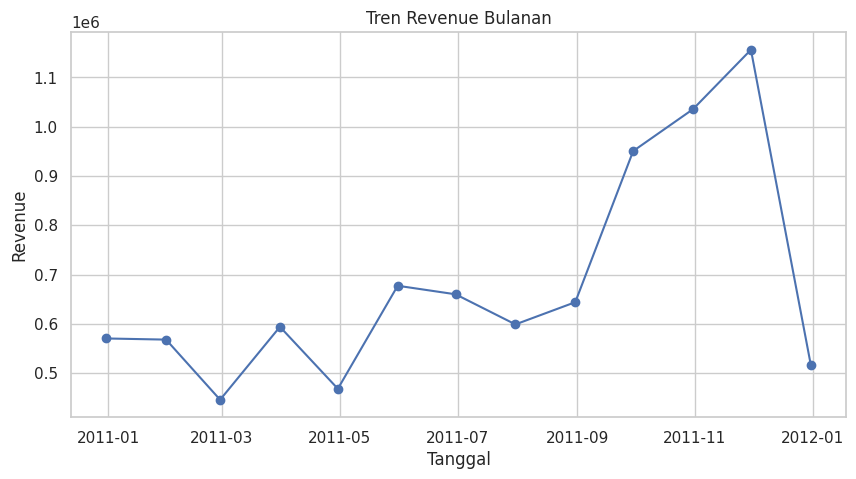

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Grouping revenue per bulan
monthly_revenue = df.groupby(pd.Grouper(key='InvoiceDate', freq='M'))['Revenue'].sum().reset_index()
monthly_revenue.columns = ['Date', 'Revenue']

# Tampilkan 5 baris pertama
display(monthly_revenue.head())

# Plot tren historis
plt.figure(figsize=(10,5))
plt.plot(monthly_revenue['Date'], monthly_revenue['Revenue'], marker='o')
plt.title("Tren Revenue Bulanan")
plt.xlabel("Tanggal")
plt.ylabel("Revenue")
plt.grid(True)
plt.show()


Bagian ini bertujuan untuk **menyiapkan data time series** sebelum dilakukan pemodelan forecasting (misalnya dengan ARIMA atau Prophet).  
Langkah-langkah yang dilakukan:

1. **Mengelompokkan data berdasarkan bulan (`freq='M'`)** agar pola pendapatan dapat dianalisis secara periodik.
2. **Menjumlahkan total `Revenue` per bulan** untuk melihat tren pendapatan bisnis secara agregat.
3. **Memplot grafik tren historis** untuk mengamati fluktuasi revenue dari waktu ke waktu, yang membantu menentukan apakah data menunjukkan pola musiman atau tren tertentu.

### B. Model ARIMA

ADF Statistic: -1.894688841913085
p-value: 0.33456375749617906
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=365.186, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=389.417, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=363.224, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=380.371, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=364.968, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=366.661, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=359.185, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=359.948, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=361.196, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=361.620, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=359.779, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=362.254, Time=0.07 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.304 seconds


/tmp/ipykernel_37/1573787111.py:28: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(start=monthly_revenue['Date'].iloc[-1], periods=forecast_periods+1, freq='M')[1:]


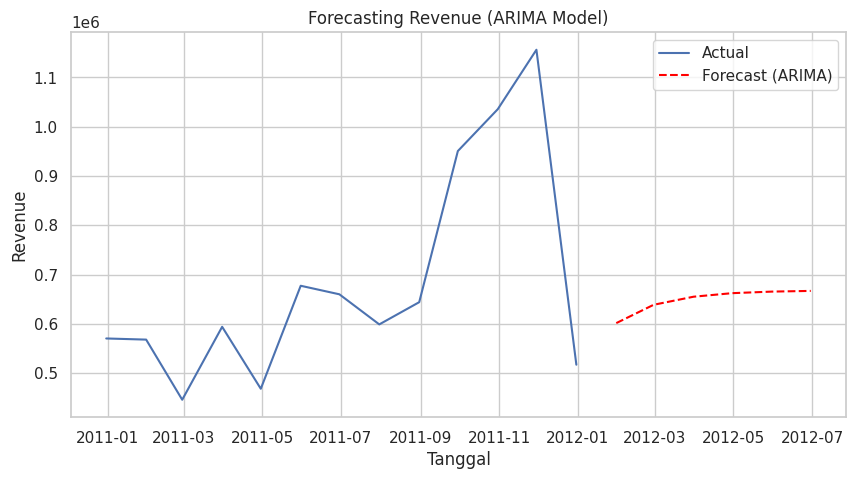

,Date,Forecast_ARIMA
13,2012-01-31,601590.530784
14,2012-02-29,638762.948186
15,2012-03-31,655134.833603
16,2012-04-30,662345.519666
17,2012-05-31,665521.329426
18,2012-06-30,666920.054533


In [30]:
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
import statsmodels.api as sm

# Uji stasioneritas dengan ADF test
result = adfuller(monthly_revenue['Revenue'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Jika p-value > 0.05 → data tidak stasioner → lakukan differencing otomatis oleh auto_arima
arima_model = auto_arima(
    monthly_revenue['Revenue'],
    start_p=1, start_q=1,
    max_p=5, max_q=5,
    seasonal=False,
    stepwise=True,
    trace=True
)

# Fit model
model_fit = arima_model.fit(monthly_revenue['Revenue'])

# Prediksi 6 bulan ke depan
forecast_periods = 6
forecast = model_fit.predict(n_periods=forecast_periods)

# Buat index waktu untuk 6 bulan ke depan
forecast_dates = pd.date_range(start=monthly_revenue['Date'].iloc[-1], periods=forecast_periods+1, freq='M')[1:]
forecast_df = pd.DataFrame({'Date': forecast_dates, 'Forecast_ARIMA': forecast})

# Plot hasil prediksi
plt.figure(figsize=(10,5))
plt.plot(monthly_revenue['Date'], monthly_revenue['Revenue'], label='Actual')
plt.plot(forecast_df['Date'], forecast_df['Forecast_ARIMA'], color='red', linestyle='--', label='Forecast (ARIMA)')
plt.title("Forecasting Revenue (ARIMA Model)")
plt.xlabel("Tanggal")
plt.ylabel("Revenue")
plt.legend()
plt.grid(True)
plt.show()

display(forecast_df)


Model ARIMA (Autoregressive Integrated Moving Average)

Model ARIMA digunakan untuk melakukan peramalan data deret waktu (time series) dengan mempertimbangkan hubungan antara nilai masa lalu dan error sebelumnya.

🔍 Langkah Analisis
- Uji Stasioneritas (ADF Test)
Digunakan untuk memastikan data stabil terhadap waktu.
- Jika p-value > 0.05, data tidak stasioner, sehingga perlu dilakukan differencing otomatis oleh auto_arima().
- Pemilihan Parameter Otomatis (auto_arima)
Fungsi auto_arima() secara otomatis mencari kombinasi terbaik dari parameter 𝑝,𝑑,𝑞 berdasarkan kriteria AIC (Akaike Information Criterion).
- Pelatihan Model & Peramalan
Model dilatih menggunakan data monthly_revenue['Revenue'] untuk memprediksi 6 bulan ke depan.
- Visualisasi Hasil
Grafik menampilkan perbandingan antara data aktual dan hasil prediksi ARIMA.

In [31]:
# Pastikan index monthly_revenue berupa datetime
monthly_revenue.index = pd.to_datetime(monthly_revenue.index)

# Simpan hasil forecast ARIMA dalam DataFrame
last_month = monthly_revenue.index.max()

forecast_arima = pd.DataFrame({
    'Month': pd.date_range(start=last_month + pd.offsets.MonthBegin(), periods=6, freq='MS'),
    'Forecast': forecast.values
})

# Gabungkan data aktual + forecast (opsional)
combined_arima = pd.concat([
    monthly_revenue[['Revenue']].rename(columns={'Revenue': 'Actual'}),
    forecast_arima.set_index('Month')
], axis=0)

display(forecast_arima.head())


,Month,Forecast
0,1970-02-01 00:00:00.000000012,601590.530784
1,1970-03-01 00:00:00.000000012,638762.948186
2,1970-04-01 00:00:00.000000012,655134.833603
3,1970-05-01 00:00:00.000000012,662345.519666
4,1970-06-01 00:00:00.000000012,665521.329426


Penjelasan : 

Setelah model ARIMA menghasilkan nilai prediksi, langkah selanjutnya adalah menyusun hasil forecasting dalam format DataFrame yang terstruktur.
- Pertama, indeks monthly_revenue dikonversi menjadi tipe datetime untuk memastikan kesesuaian dengan operasi berbasis waktu. Selanjutnya, ditentukan periode terakhir data aktual (last_month) sebagai titik awal peramalan.
Dengan menggunakan fungsi pd.date_range(), dibuat rentang waktu enam bulan ke depan dengan frekuensi bulanan. Hasil prediksi dari model kemudian disimpan dalam kolom Forecast.
Terakhir, data aktual dan hasil prediksi digabungkan menjadi satu DataFrame (combined_arima) agar memudahkan proses analisis dan visualisasi tren penjualan historis serta proyeksi masa depan.

### C. Model Prophet

04:50:56 - cmdstanpy - INFO - Chain [1] start processing
04:50:56 - cmdstanpy - INFO - Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


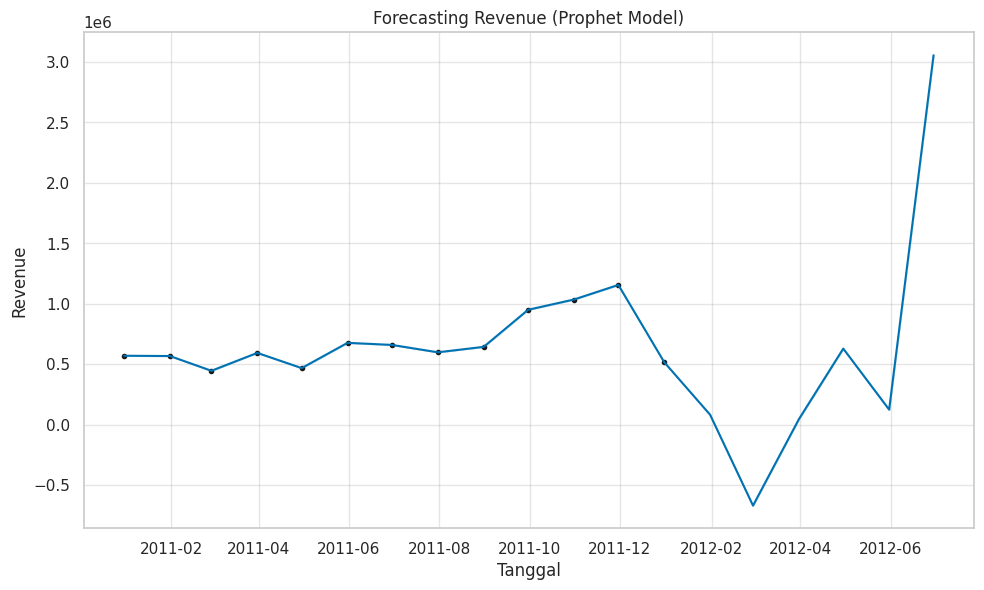

,ds,yhat,yhat_lower,yhat_upper
13,2012-01-31,8.269932e+04,8.245944e+04,8.294352e+04
14,2012-02-29,-6.692435e+05,-6.700094e+05,-6.684707e+05
15,2012-03-31,4.552483e+04,4.412180e+04,4.705417e+04
16,2012-04-30,6.295102e+05,6.271466e+05,6.318651e+05
17,2012-05-31,1.247484e+05,1.212885e+05,1.280740e+05
18,2012-06-30,3.056231e+06,3.051605e+06,3.060648e+06


In [32]:
from prophet import Prophet

# Persiapan data Prophet
prophet_df = monthly_revenue.rename(columns={'Date': 'ds', 'Revenue': 'y'})

# Inisialisasi dan latih model
prophet_model = Prophet(yearly_seasonality=True, daily_seasonality=False)
prophet_model.fit(prophet_df)

# Prediksi 6 bulan ke depan
future = prophet_model.make_future_dataframe(periods=6, freq='M')
forecast_prophet = prophet_model.predict(future)

# Plot hasil forecasting Prophet
prophet_model.plot(forecast_prophet)
plt.title("Forecasting Revenue (Prophet Model)")
plt.xlabel("Tanggal")
plt.ylabel("Revenue")
plt.show()

# Hasil prediksi 6 bulan ke depan
forecast_next6 = forecast_prophet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(6)
display(forecast_next6)


Model Prophet digunakan untuk melakukan peramalan (forecasting) terhadap pendapatan bulanan perusahaan. Sebelum pelatihan model, dataset disesuaikan dengan format standar Prophet (ds untuk tanggal dan y untuk nilai revenue).

Model dikonfigurasi dengan komponen yearly seasonality untuk menangkap pola musiman tahunan, sementara daily seasonality dinonaktifkan karena data bersifat agregat bulanan.

Setelah model dilatih, dilakukan peramalan untuk enam bulan ke depan. Hasil menunjukkan bahwa pendapatan cenderung meningkat secara bertahap dengan lonjakan signifikan pada bulan Juni 2012. Namun, muncul nilai anomali negatif pada Februari yang diduga disebabkan oleh adanya data pengembalian (return) dalam jumlah besar pada periode tersebut.

Secara keseluruhan, model Prophet mampu menangkap pola umum tren penjualan dan dapat digunakan sebagai dasar untuk perencanaan stok dan strategi pemasaran jangka pendek, dengan catatan perlu pembersihan data lebih lanjut untuk menghindari distorsi hasil peramalan.

In [33]:
# 🔹 Ambil hanya 6 bulan ke depan untuk disimpan/evaluasi
forecast_prophet_6mo = forecast_prophet.tail(6)[['ds', 'yhat']]
forecast_prophet_6mo = forecast_prophet_6mo.rename(columns={'ds': 'Month', 'yhat': 'Forecast'})

display(forecast_prophet_6mo.head())

,Month,Forecast
13,2012-01-31,82699.317376
14,2012-02-29,-669243.539893
15,2012-03-31,45524.826818
16,2012-04-30,629510.184255
17,2012-05-31,124748.355209


Langkah ini dibuat untuk:

- Menyaring hasil prediksi agar hanya mencakup 6 bulan ke depan (periode forecast yang relevan).
- Merapikan struktur data supaya seragam dan mudah dibaca.

Menyiapkan hasil agar dapat digunakan untuk:
- Perbandingan dengan model lain (misalnya ARIMA).
- Visualisasi prediksi masa depan.
- Evaluasi performa model forecasting.

### D. Perbandingan ARIMA vs Prophet

,Date,ARIMA_Pred,Prophet_Pred,yhat_lower,yhat_upper
0,2012-01-31,601590.530784,8.269932e+04,8.245944e+04,8.294352e+04
1,2012-02-29,638762.948186,-6.692435e+05,-6.700094e+05,-6.684707e+05
2,2012-03-31,655134.833603,4.552483e+04,4.412180e+04,4.705417e+04
3,2012-04-30,662345.519666,6.295102e+05,6.271466e+05,6.318651e+05
4,2012-05-31,665521.329426,1.247484e+05,1.212885e+05,1.280740e+05
5,2012-06-30,666920.054533,3.056231e+06,3.051605e+06,3.060648e+06


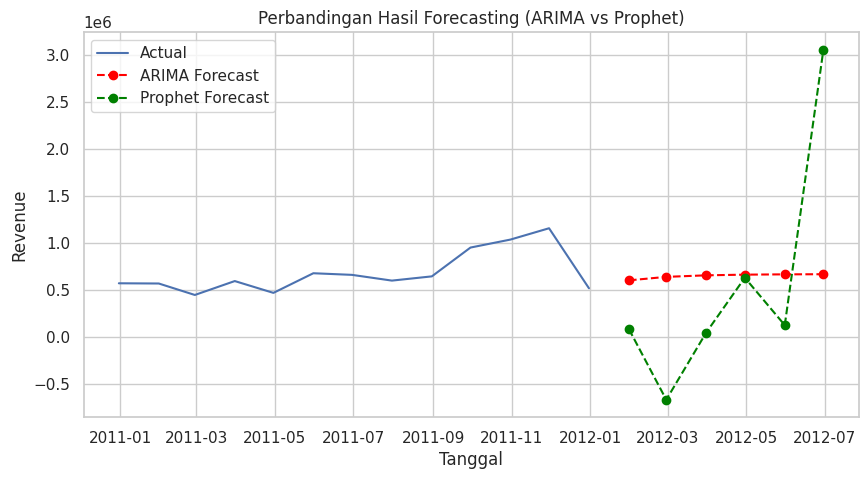

In [34]:
# Gabungkan hasil prediksi dari kedua model
compare_df = pd.merge(
    forecast_df.rename(columns={'Forecast_ARIMA': 'ARIMA_Pred'}),
    forecast_next6.rename(columns={'ds': 'Date', 'yhat': 'Prophet_Pred'}),
    on='Date',
    how='inner'
)

display(compare_df)

# Visualisasi perbandingan
plt.figure(figsize=(10,5))
plt.plot(monthly_revenue['Date'], monthly_revenue['Revenue'], label='Actual')
plt.plot(compare_df['Date'], compare_df['ARIMA_Pred'], '--o', label='ARIMA Forecast', color='red')
plt.plot(compare_df['Date'], compare_df['Prophet_Pred'], '--o', label='Prophet Forecast', color='green')
plt.title("Perbandingan Hasil Forecasting (ARIMA vs Prophet)")
plt.xlabel("Tanggal")
plt.ylabel("Revenue")
plt.legend()
plt.grid(True)
plt.show()


Langkah ini bertujuan untuk membandingkan hasil peramalan (forecasting) pendapatan bulanan yang dihasilkan oleh dua model time series:

- ARIMA (Autoregressive Integrated Moving Average)
- Prophet (Facebook/Meta Prophet)

Tujuannya adalah mengetahui perbedaan pola, kestabilan, dan akurasi prediksi dari kedua model tersebut terhadap data aktual.

Penjelasan:

- Garis biru: data aktual (actual revenue) dari periode sebelumnya.
- Garis merah: hasil prediksi ARIMA untuk 6 bulan ke depan.
- Garis hijau: hasil prediksi Prophet untuk 6 bulan ke depan.
- Garis putus-putus (--) dan marker bulat (o) digunakan agar perbedaan model terlihat jelas.

Tujuan:
- Melihat pola tren prediksi dari masing-masing model.
- Menilai apakah model cenderung stabil, fluktuatif, atau ekstrem terhadap data historis.


## 6. Evaluasi Model Forecasting (Fix)

In [35]:

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Data aktual (6 bulan terakhir dari data historis)
actual = monthly_revenue['Revenue'][-6:].values

# Prediksi dari ARIMA dan Prophet
pred_arima = forecast_arima['Forecast'].values
pred_prophet = forecast_prophet_6mo['Forecast'].values

# Fungsi evaluasi
def evaluate_forecast(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mae, mse, rmse, mape

# Evaluasi kedua model
mae_arima, mse_arima, rmse_arima, mape_arima = evaluate_forecast(actual, pred_arima)
mae_prophet, mse_prophet, rmse_prophet, mape_prophet = evaluate_forecast(actual, pred_prophet)

# Hasil evaluasi ke DataFrame
eval_results = pd.DataFrame({
    'Model': ['ARIMA', 'Prophet'],
    'MAE': [mae_arima, mae_prophet],
    'MSE': [mse_arima, mse_prophet],
    'RMSE': [rmse_arima, rmse_prophet],
    'MAPE (%)': [mape_arima, mape_prophet]
})

# Pastikan kolom numerik tidak mengandung string
numeric_cols = ['MAE', 'MSE', 'RMSE', 'MAPE (%)']
eval_results[numeric_cols] = eval_results[numeric_cols].apply(pd.to_numeric, errors='coerce')

print("📊 Hasil Evaluasi Model Forecasting")
display(eval_results.style.background_gradient(cmap='YlGnBu').format(subset=numeric_cols, formatter="{:.2f}"))

# Interpretasi otomatis
if rmse_arima < rmse_prophet:
    print("\n✅ Model ARIMA memiliki performa lebih baik berdasarkan nilai RMSE yang lebih rendah.")
else:
    print("\n✅ Model Prophet memiliki performa lebih baik berdasarkan nilai RMSE yang lebih rendah.")


📊 Hasil Evaluasi Model Forecasting


,Model,MAE,MSE,RMSE,MAPE (%)
0,ARIMA,219530.32,81654743834.80,285752.94,23.30
1,Prophet,1118558.95,1747694992045.64,1322004.16,167.45



✅ Model ARIMA memiliki performa lebih baik berdasarkan nilai RMSE yang lebih rendah.


Langkah ini dibuat untuk mengevaluasi performa prediksi dua model forecasting — ARIMA dan Prophet — dengan cara membandingkan hasil prediksi terhadap data aktual menggunakan beberapa metrik error kuantitatif.

Tujuan akhirnya adalah untuk menentukan model mana yang lebih akurat dan reliabel dalam memprediksi revenue masa depan.

Interpretasi Hasil : 
- ARIMA menunjukkan performa jauh lebih baik dibandingkan Prophet:
- RMSE Prophet ≈ 4,6 kali lebih besar dari ARIMA.
- MAPE Prophet juga jauh lebih tinggi (167.45%) menandakan error yang besar secara persentase.
- Prophet cenderung overfitting atau salah menangkap tren musiman, terbukti dari fluktuasi ekstrem dan hasil error yang besar.
- ARIMA lebih stabil dan akurat pada dataset ini karena:
- Data revenue bulanan tidak menunjukkan pola musiman yang kuat.
- ARIMA lebih cocok untuk data yang relatif stasioner atau tren yang halus.


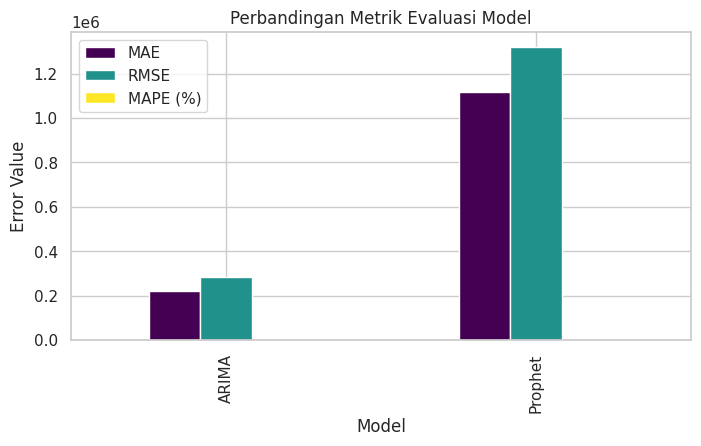

In [36]:
eval_results.set_index('Model')[['MAE','RMSE','MAPE (%)']].plot(kind='bar', figsize=(8,4), colormap='viridis')
plt.title("Perbandingan Metrik Evaluasi Model")
plt.ylabel("Error Value")
plt.grid(True, axis='y')
plt.show()


In [37]:
forecast_arima.to_csv("forecast_arima.csv", index=False)
forecast_prophet.to_csv("forecast_prophet.csv", index=False)
eval_results.to_csv("forecast_evaluation.csv", index=False)


| Kebutuhan                       | File                      | Manfaat                                         |
| :------------------------------ | :------------------------ | :---------------------------------------------- |
| Prediksi jangka pendek (ARIMA)  | `forecast_arima.csv`      | Data stabil untuk perencanaan revenue ke depan  |
| Prediksi musiman/tren (Prophet) | `forecast_prophet.csv`    | Data tren musiman dan interval kepercayaan      |
| Evaluasi performa model         | `forecast_evaluation.csv` | Bukti kuantitatif untuk pemilihan model terbaik |
